In [ ]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.metrics import f1_score
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [ ]:
# data = pd.read_csv('_train_sem09__1_.zip')

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Skillfactory/data/_train_sem09__1_.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.head(2)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


Проверяем выборку на дисбаланс

Activity is 0: 45.77%
Activity is 1: 54.23%


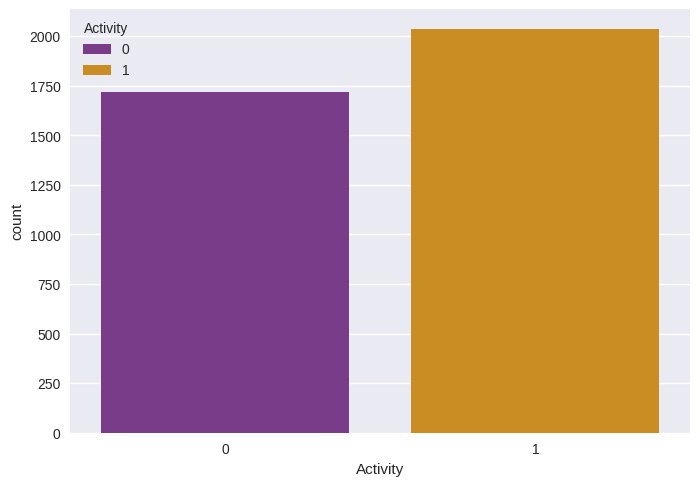

In [ ]:
sns.countplot(data=data, x='Activity', palette='CMRmap', hue='Activity')
activity_percent = data['Activity'].value_counts(normalize=True) * 100
print('Activity is 0: {:.2f}%'.format(activity_percent[0]))
print('Activity is 1: {:.2f}%'.format(activity_percent[1]))

Выборку можно считать сбалансированной.  
Разделим выборку на тренировочную и тестовую в соотношении 80/20.

In [ ]:
X, y = data.drop('Activity', axis=1), data['Activity']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
RANDOM_STATE = 42

# Оптимизация гиперпараметров модели

### **Логистическая регрессия**

Зафиксируем метрику F1-score, полученную без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [ ]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
                                          random_state=RANDOM_STATE,
                                          # max_iter=50
                                          )
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [ ]:
y_test_pred = log_reg.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.780


Зададим пространство поиска гиперпараметров.

In [ ]:
s = ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'liblinear', 'saga']
p = ['l1', 'l2', None]
с = [0.1, 0.5, 1, 1.5, 2]

### <center> **GridSearchCV**

Пробуем подобрать оптимальные параметры с помощью поиска по сетке

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid_lr = [{'solver': s[:4],   # алгоритм оптимизации
                          #  ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']
                  'penalty': [p[1]],                                            # тип регуляризации
                          # ['l2']
                  'C': с},                                # уровень силы регуляризации

                 {'solver': s[-2:],  # ['liblinear', 'saga']
                  'penalty': p[:2],  # ['l1', 'l2']
                  'C': с},

                 {'solver': [s[-1]],  # ['saga']
                  'penalty': [p[-1]]},  # [None]
                  ]

In [ ]:
grid_search_1 = GridSearchCV(
                              estimator=log_reg,
                              param_grid=param_grid_lr,
                              scoring = 'f1',
                              cv=5,
                              n_jobs = -1
                          )

%time grid_search_1.fit(X_train, y_train)

CPU times: user 7.94 s, sys: 1.62 s, total: 9.56 s
Wall time: 13min 2s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.1, 0.5, 1, 1.5, 2], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                     'sag']},
                         {'C': [0.1, 0.5, 1, 1.5, 2], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']},
                         {'penalty': [None], 'solver': ['saga']}],
             scoring='f1')

In [ ]:
y_test_pred = grid_search_1.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

f1_score на тестовом наборе: 0.776
Наилучшие значения гиперпараметров: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.448060,0.579925,0.087123,0.034378,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.814815,0.787692,0.761905,0.790419,0.773134,0.785593,0.017877,6
1,5.968542,0.821359,0.063332,0.016272,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.814815,0.787692,0.761905,0.790419,0.774963,0.785959,0.017636,3


In [ ]:
result_cv.shape  # количество строк - это сумма комбинаций в каждом из наборов

(41, 16)

In [ ]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

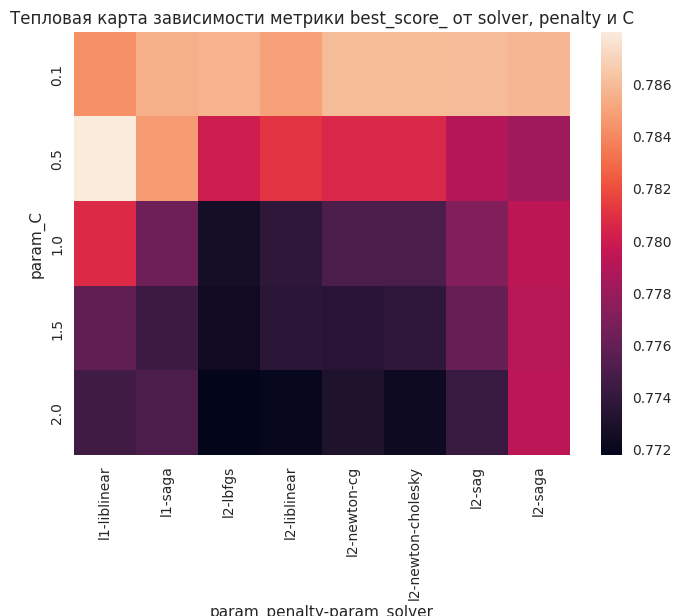

In [ ]:
# Отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns=['param_penalty', 'param_solver'])
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики best_score_ от solver, penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Изучим область предполагаемого максимума метрики подробнее с помощью новой сетки.

In [ ]:
param_grid_2 = [{ 'solver': ['liblinear'],             # алгоритм оптимизации
                'penalty': ['l1'],      # тип регуляризации
                'C': np.arange(0.01, 1, 0.05)}  # уровень силы регуляризации
                ]

grid_search_2 = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_2,
    scoring = 'f1',
    cv=5,
    n_jobs = -1
)

%time grid_search_2.fit(X_train, y_train)

CPU times: user 990 ms, sys: 146 ms, total: 1.14 s
Wall time: 39.3 s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                          'penalty': ['l1'], 'solver': ['liblinear']}],
             scoring='f1')

In [ ]:
y_test_pred = grid_search_2.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

f1_score на тестовом наборе: 0.774
Наилучшие значения гиперпараметров: {'C': 0.16000000000000003, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Результаты кросс-валидации
result_cv_2 = pd.DataFrame(grid_search_2.cv_results_)
result_cv_2.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.273688,0.016735,0.047109,0.012520,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.774691,0.773885,0.756672,0.745710,0.737679,0.757727,0.014808,20
1,0.338534,0.047610,0.068485,0.008568,0.06,l1,liblinear,"{'C': 0.060000000000000005, 'penalty': 'l1', '...",0.793363,0.784496,0.762048,0.766214,0.747287,0.770682,0.016414,19


In [ ]:
result_cv_2.shape

(20, 16)

In [ ]:
result_cv_2[(result_cv_2['param_penalty']=='l1') & (result_cv_2['param_C']==np.float64(0.16000000000000003))]#['mean_test_score']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.630446,0.173398,0.051262,0.007549,0.16,l1,liblinear,"{'C': 0.16000000000000003, 'penalty': 'l1', 's...",0.810651,0.798165,0.772861,0.785924,0.784962,0.790513,0.012865,1


In [ ]:
round(grid_search_2.best_score_, 6)  # mean_test_score

0.790513

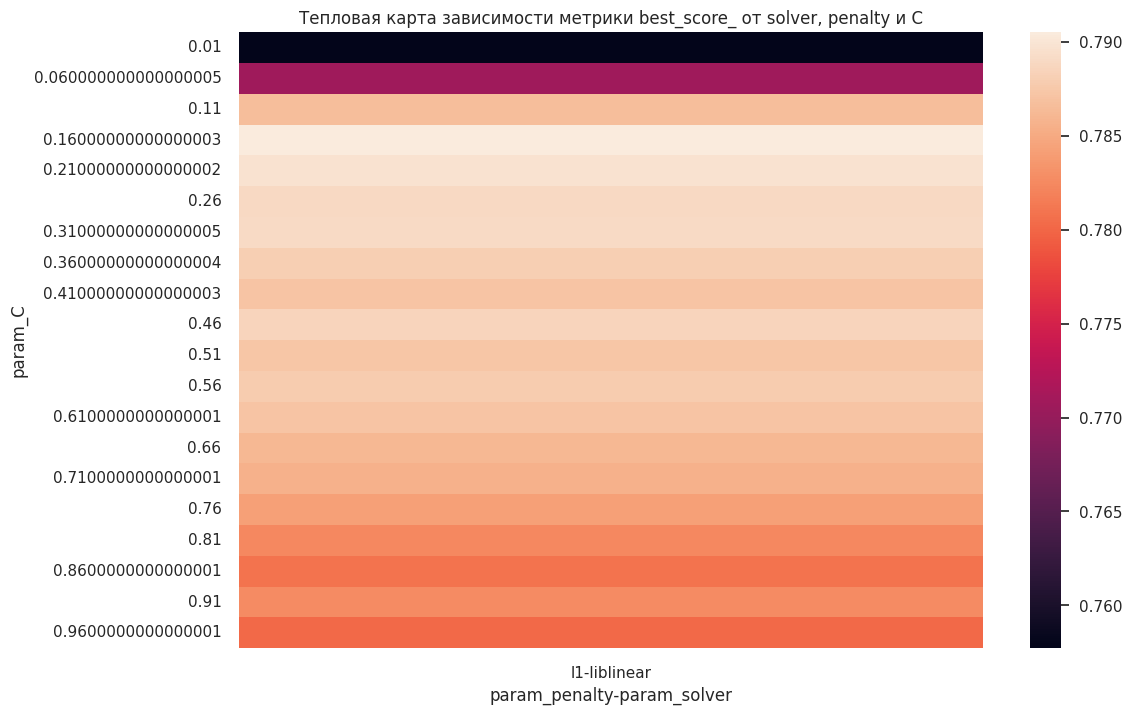

In [ ]:
# Отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_2.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns=['param_penalty', 'param_solver'])
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики best_score_ от solver, penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Значения метрики f1_score на тестовом наборе не увеличились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> **RandomizedSearchCV**

Проведем поиск оптимальных параметров среди тех же значений, что и для GridSearchCV. Количество итераций выберем равным числу комбинаций параметров для GridSearchCV. Значительного выигрыша по времени не ожидается, но можно не использовать повторный поиск с более мелкой сеткой.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = param_grid_lr

random_search = RandomizedSearchCV(
                                    estimator=log_reg,
                                    param_distributions=param_distributions,
                                    scoring = 'f1',
                                    cv=5,
                                    n_iter = result_cv.shape[0],
                                    n_jobs = -1
                                )

%time random_search.fit(X_train, y_train)

CPU times: user 7.61 s, sys: 1.44 s, total: 9.04 s
Wall time: 12min 42s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=41, n_jobs=-1,
                   param_distributions=[{'C': [0.1, 0.5, 1, 1.5, 2],
                                         'penalty': ['l2'],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'newton-cholesky', 'sag']},
                                        {'C': [0.1, 0.5, 1, 1.5, 2],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear', 'saga']},
                                        {'penalty': [None],
                                         'solver': ['saga']}],
                   scoring='f1')

In [ ]:
y_test_pred = random_search.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

f1_score на тестовом наборе: 0.776
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5}


Метрику f1_score на тестовом наборе улучшить не удалось.

### <center> **Hyperopt**

In [ ]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов
from hyperopt import space_eval  # для вывода лучших параметров

Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.

In [ ]:
# s = ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'liblinear', 'saga']
# p = ['l1', 'l2', None]
# с = [0.1, 0.5, 1, 1.5, 2]

In [ ]:
space = hp.choice('parameter_combinations', [
                                             {'solver': s[0],  # 'lbfgs'
                                              'penalty': p[1],  # 'l2'
                                              'C': hp.choice('C_0', с)},

                                              {'solver': s[1],  # 'newton-cg'
                                              'penalty': p[1],  # 'l2'
                                              'C': hp.choice('C_1', с)},

                                              {'solver': s[2],  # 'newton-cholesky'
                                              'penalty': p[1],  # 'l2'
                                              'C': hp.choice('C_2', с)},

                                              {'solver': s[3],  # 'sag'
                                              'penalty': p[1],  # 'l2'
                                              'C': hp.choice('C_3', с)},

                                              {'solver': s[-2],  # 'liblinear'
                                              'penalty': p[0],  # 'l1'
                                              'C': hp.choice('C_4', с)},

                                              {'solver': s[-2],  # 'liblinear'
                                              'penalty': p[1],  # 'l2'
                                              'C': hp.choice('C_5', с)},

                                              {'solver': s[-1],  # 'saga'
                                              'penalty': p[0],  # 'l1'
                                              'C': hp.choice('C_6', с)},

                                              {'solver': s[-1],  # 'saga'
                                              'penalty': p[1],  # 'l2'
                                              'C': hp.choice('C_7', с)},

                                              {'solver': s[-1],  # 'saga'
                                              'penalty': p[2],  # None
                                              'C': hp.choice('C_8', [1])}
                                            ]
                                            )

In [ ]:
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):

    params = {'solver': params['solver'],
              'penalty': params['penalty'],
              'C': params['C']
             }

    model = linear_model.LogisticRegression(
                                            **params,
                                            random_state=random_state,
                                            max_iter=50
                                            )

    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(
                            model,
                            X,
                            y,
                            cv=cv,
                            scoring='f1',
                            n_jobs=-1
                            ).mean()

    return -score

In [ ]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_lr, # наша функция
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals=result_cv.shape[0], # максимальное количество итераций
            trials=trials, # логирование результатов
            rstate=np.random.default_rng(RANDOM_STATE)# фиксируем для повторяемости результата
            )

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 41/41 [07:26<00:00, 10.90s/trial, best loss: -0.7879974895090788]
Наилучшие значения гиперпараметров {'C_4': 1, 'parameter_combinations': 4}
CPU times: user 6 s, sys: 2.03 s, total: 8.03 s
Wall time: 7min 26s


In [ ]:
best_hp_lr = space_eval(space, best)

print("Наилучшие значения гиперпараметров: {}".format(best_hp_lr))

Наилучшие значения гиперпараметров: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# рассчитаем точность для тестовой выборки
model_HO_best = linear_model.LogisticRegression(
                                                solver = best_hp_lr['solver'],
                                                penalty = best_hp_lr['penalty'],
                                                C = best_hp_lr['C'],
                                                random_state=RANDOM_STATE,
                                                max_iter=50
                                                )

model_HO_best.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=50, penalty='l1', random_state=42,
                   solver='liblinear')

In [ ]:
y_train_pred = model_HO_best.predict(X_train)

print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model_HO_best.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.854
f1_score на тестовом наборе: 0.776


С помощью Hyperopt метрику f1_score на тестовом наборе не удалось улучшить.

### <center> Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
# s = ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'liblinear', 'saga']
# p = ['l1', 'l2', None]
# с = [0.1, 0.5, 1, 1.5, 2]

In [ ]:
def optuna_lr(trial):
    # пространство гиперпараметров
    solver = trial.suggest_categorical('solver', s)

    if solver == 'saga' or solver == 'liblinear':
      penalty = trial.suggest_categorical('penalty_l1_l2', ['l1', 'l2'])
    else:
      penalty = trial.suggest_categorical('penalty_l2', ['l2'])

    C = trial.suggest_float('C', с[0], 2.6, step=0.5)

    model = linear_model.LogisticRegression(
                                            solver=solver,
                                            penalty=penalty,
                                            C=C,
                                            random_state=RANDOM_STATE,
                                            max_iter=50
                                        )

    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(
                            model,
                            X_train,
                            y_train,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1
                            ).mean()

    return score

In [ ]:
%%time
# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)

study_lr = optuna.create_study(
                                sampler=sampler,
                                study_name='LogisticRegression',
                                direction='maximize'
                                )

study_lr.optimize(
                  optuna_lr,
                  n_trials=20
                  )

[I 2024-06-29 08:16:53,079] A new study created in memory with name: LogisticRegression
[I 2024-06-29 08:17:05,423] Trial 0 finished with value: 0.7859587576528776 and parameters: {'solver': 'newton-cg', 'penalty_l2': 'l2', 'C': 0.1}. Best is trial 0 with value: 0.7859587576528776.
[I 2024-06-29 08:17:11,688] Trial 1 finished with value: 0.787065257935971 and parameters: {'solver': 'liblinear', 'penalty_l1_l2': 'l1', 'C': 0.6}. Best is trial 1 with value: 0.787065257935971.
[I 2024-06-29 08:17:15,243] Trial 2 finished with value: 0.7733293937898014 and parameters: {'solver': 'liblinear', 'penalty_l1_l2': 'l2', 'C': 1.1}. Best is trial 1 with value: 0.787065257935971.
[I 2024-06-29 08:17:18,367] Trial 3 finished with value: 0.7787560004527956 and parameters: {'solver': 'lbfgs', 'penalty_l2': 'l2', 'C': 0.6}. Best is trial 1 with value: 0.787065257935971.
[I 2024-06-29 08:18:01,025] Trial 4 finished with value: 0.7716467869501512 and parameters: {'solver': 'newton-cholesky', 'penalty_l2'

CPU times: user 2.94 s, sys: 1.13 s, total: 4.07 s
Wall time: 3min 57s


In [ ]:
study_lr.best_params

{'solver': 'liblinear', 'penalty_l1_l2': 'l1', 'C': 0.6}

In [ ]:
best_hp_lr = study_lr.best_params

In [ ]:
best_hp_lr['penalty'] = best_hp_lr['penalty_l1_l2']
del best_hp_lr['penalty_l1_l2']
best_hp_lr

{'solver': 'liblinear', 'C': 0.6, 'penalty': 'l1'}

In [ ]:
# Модель с лучшими параметрами
optuna_lr = linear_model.LogisticRegression(
                                            **best_hp_lr,#study_lr.best_params,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE,
                                            max_iter=50
                                          )

optuna_lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


LogisticRegression(C=0.6, max_iter=50, n_jobs=-1, penalty='l1', random_state=42,
                   solver='liblinear')

In [ ]:
y_train_pred = optuna_lr.predict(X_train)
y_test_pred = optuna_lr.predict(X_test)

print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')
print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty_l1_l2': 'l1', 'C': 0.6}
f1_score на обучающем наборе: 0.860
f1_score на тестовом наборе: 0.775


С помощью Optuna метрику f1_score на тестовом наборе улучшить не удалось.

### **Случайный лес**

Проделаем аналогичные действия для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=RANDOM_STATE)

#Обучаем модель
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#Выводим значения метрики
y_train_pred = rf.predict(X_train)

print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = rf.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.000
f1_score на тестовом наборе: 0.805


Зададим пространство поиска гиперпараметров.

In [ ]:
#  n_estimators
n_est = [100, 400, 100]  # l[0] - min, l[1] - max, l[2] - step
#  min_samples_leaf
msl = [4, 10, 1]
#  max_depth
md = [5, 50, 10]

### <center> **GridSearchCV**

In [ ]:
# Сетка параметров
param_grid = {'n_estimators': list(range(n_est[0], n_est[1], n_est[2])),      # n_est = [100, 400, 100]
              'min_samples_leaf': list(range(msl[0], msl[1], msl[2])),        # msl = [4, 10, 1]
              'max_depth': list(np.linspace(md[0], md[1], md[2], dtype=int))  # md = [5, 50, 10]
              }
# Поиск по сетке параметров с кросс-валидацией
grid_search_forest = GridSearchCV(
                                  estimator=ensemble.RandomForestClassifier(random_state=RANDOM_STATE),
                                  param_grid=param_grid,
                                  cv=5,
                                  n_jobs = -1
                                )

%time grid_search_forest.fit(X_train, y_train)

CPU times: user 24.9 s, sys: 4.19 s, total: 29.1 s
Wall time: 33min 4s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [4, 5, 6, 7, 8, 9],
                         'n_estimators': [100, 200, 300]})

In [ ]:
y_train_pred = grid_search_forest.predict(X_train)

print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search_forest.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

f1_score на обучающем наборе: 0.929
f1_score на тестовом наборе: 0.801
Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 6, 'n_estimators': 300}


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> **RandomizedSearchCV**

Проведем поиск оптимальных параметров среди тех же значений, что и для GridSearchCV.

In [ ]:
# Сетка параметров
param_distributions = param_grid

# Поиск по сетке параметров с кросс-валидацией
random_search_forest = RandomizedSearchCV(
                                          estimator=ensemble.RandomForestClassifier(random_state=RANDOM_STATE),
                                          param_distributions=param_distributions,
                                          cv=5,
                                          n_iter = 20,
                                          n_jobs = -1
                                      )

%time random_search_forest.fit(X_train, y_train)

CPU times: user 6.65 s, sys: 348 ms, total: 7 s
Wall time: 3min 37s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50],
                                        'min_samples_leaf': [4, 5, 6, 7, 8, 9],
                                        'n_estimators': [100, 200, 300]})

In [ ]:
y_train_pred = random_search_forest.predict(X_train)

print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search_forest.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

f1_score на обучающем наборе: 0.929
f1_score на тестовом наборе: 0.801
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 6, 'max_depth': 40}


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> **Hyperopt**

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [ ]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', n_est[0], n_est[1], n_est[2]),   # n_est = [100, 400, 100]
       'max_depth' : hp.quniform('max_depth', md[0], md[1], md[2]),                 # md = [5, 50, 10]
       'min_samples_leaf': hp.quniform('min_samples_leaf', msl[0], msl[1], msl[2])  # msl = [4, 10, 1]
      }

In [ ]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }

    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(
                                            **params,
                                            random_state=random_state,
                                            n_jobs=-1
                                            )


    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(
                            model,
                            X,
                            y,
                            cv=cv,
                            scoring='f1',
                            n_jobs=-1
                            ).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals=20, # максимальное количество итераций
            trials=trials, # логирование результатов
            rstate=np.random.default_rng(RANDOM_STATE)# фиксируем для повторяемости результата
         )

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [04:00<00:00, 12.00s/trial, best loss: -0.8122324543473132]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 4.0, 'n_estimators': 100.0}
CPU times: user 2.73 s, sys: 900 ms, total: 3.63 s
Wall time: 4min


In [ ]:
best_hp_rf = space_eval(space, best)

print("Наилучшие значения гиперпараметров: {}".format(best_hp_rf))

Наилучшие значения гиперпараметров: {'max_depth': 30.0, 'min_samples_leaf': 4.0, 'n_estimators': 100.0}


In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
                                        random_state=RANDOM_STATE,
                                        n_estimators=int(best['n_estimators']),
                                        max_depth=int(best['max_depth']),
                                        min_samples_leaf=int(best['min_samples_leaf'])
                                    )
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=4, random_state=42)

In [ ]:
y_train_pred = model.predict(X_train)

print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.955
f1_score на тестовом наборе: 0.808


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

### <center> Optuna

In [ ]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', n_est[0], n_est[1], step=n_est[2])    # n_est = [100, 400, 100]
    max_depth = trial.suggest_int('max_depth', md[0], md[1] - 5, step=md[2])                   # md = [5, 50, 10]
    min_samples_leaf = trial.suggest_int('min_samples_leaf', msl[0], msl[1], step=msl[2])  # msl = [4, 10, 1]

  # создаем модель
    model = ensemble.RandomForestClassifier(
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                            )
  # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(
                            model,
                            X_train,
                            y_train,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1
                            ).mean()

    return score

In [ ]:
%%time
# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)

study_rf = optuna.create_study(
                                sampler=sampler,
                                study_name='RandomForestClassifier',
                                direction='maximize'
                                )

study_rf.optimize(optuna_rf,
                  n_trials=20
                  )

[I 2024-06-29 09:03:36,707] A new study created in memory with name: RandomForestClassifier
[I 2024-06-29 09:03:51,478] Trial 0 finished with value: 0.8092052810417123 and parameters: {'n_estimators': 200, 'max_depth': 45, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8092052810417123.
[I 2024-06-29 09:04:01,253] Trial 1 finished with value: 0.7655659158799708 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8092052810417123.
[I 2024-06-29 09:04:07,257] Trial 2 finished with value: 0.8029320972689395 and parameters: {'n_estimators': 100, 'max_depth': 45, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8092052810417123.
[I 2024-06-29 09:04:18,827] Trial 3 finished with value: 0.7670891358632044 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8092052810417123.
[I 2024-06-29 09:04:40,215] Trial 4 finished with value: 0.8116033295703724 and parameters: {'n_e

CPU times: user 3.5 s, sys: 1.18 s, total: 4.68 s
Wall time: 5min 6s


In [ ]:
# Модель с лучшими параметрами
optuna_rf = ensemble.RandomForestClassifier(
                                            **study_rf.best_params,
                                            class_weight='balanced',
                                            n_jobs=-1,
                                            random_state=RANDOM_STATE
                                        )
optuna_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=45,
                       min_samples_leaf=6, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
y_train_pred = optuna_rf.predict(X_train)
y_test_pred = optuna_rf.predict(X_test)

print(f'Наилучшие значения гиперпараметров: {study_rf.best_params}')
print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров: {'n_estimators': 400, 'max_depth': 15, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.935
f1_score на тестовом наборе: 0.785


Значения метрики f1_score на тестовом наборе не изменились, комбинация внешних параметров лучше, чем заданы по умолчанию не найдена.

In [1]:
!pip freeze -> google_requirements.txt